<a href="https://colab.research.google.com/github/savitaChari/W207-Final-Project-Group3_Section6/blob/main/EDA/DataPreprocessing_FeatureEngineeeringV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA PREPROCESSING AND FEATURE ENGINEERING

### Background
To ensure our models are based on significant, abundant data, we began by executing data preprocessing techniques including reverse hot encoding of sparse data, scaling our data, and feature selecting relevant attributes. These techniques will help drive the high accuracies in different types of models used to predict forest cover types.




### SETUP
<hr>

In [31]:
import pandas as pd
import numpy as np
import random 
import itertools 
from zipfile import ZipFile

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

### GET DATA
<hr>

In [2]:
def get_data():
    with ZipFile("covtype.zip") as myzip:
        data = myzip.open("covtype.csv")
        df = pd.read_csv(data)

    return df

Reverse one-hot encoding is used to consolidate multiple sparse data elements into one element. Because our 40 Soil Type elements are 40 separate, sparse attributes all defining different types of soil and similarly, our wilderness area attributes are 4 different attributes all defining which of the four types of wilderness areas are present, we thought both features would benefit from performing reverse one-hot encoding.

In [3]:
###### TODO: Investigate a better way to do this. ######

def reverse_encode(relevant_subset):
    '''
    This function reverses one-hot encoding for into rank-encoded representations
    Parameters: an subset of relevant columns of the same type, which we are trying to reverse encode
    Output: a title-less list of the encoded variable in numerical data
    '''

    num_list =[]
    for i in relevant_subset.iloc:
        ix = 1
        for j in i:
            if j ==1:
                num_list.append(ix)
            else: 
                ix +=1
                
    print('The new list has the following elements: ' + str(set(num_list)))
    if relevant_subset.shape[0] == len(num_list):
        return num_list
    else: print('Error in compiling list: lengths of the two lists do not match.')


In [4]:
tree_df = get_data() # instantiate are tree datafrime
soil_df = tree_df.loc[:,'Soil_Type1':'Soil_Type40'] # define our soul subset dataframe
wilderness_df = tree_df.loc[:,'Wilderness_Area1':'Wilderness_Area4'] # define our wilderness subset dataframe
cont_df = tree_df.loc[:,'Elevation':'Horizontal_Distance_To_Fire_Points'] # dataframe of remaining, continuous variables

In [5]:
# reverse one-hot-encode our soil and wilderness dataframes
w = reverse_encode(wilderness_df)
s = reverse_encode(soil_df)

The new list has the following elements: {1, 2, 3, 4}
The new list has the following elements: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40}


In [6]:
# add our new features to the remaining, continuous varaiables dataframe
cont_df['Wilderness'] = w
cont_df['SoilType'] = s

forest_df = cont_df
print(forest_df.head())

   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       2596      51      3                               258   
1       2590      56      2                               212   
2       2804     139      9                               268   
3       2785     155     18                               242   
4       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            221             232            148   
1            220             235            151   
2            234             238   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Additionally, we scaled our data to ensure the distributions were similar and to eliminate any noisy data or outliers having a large impact on our model.

In [7]:
# scale our data (subtract mean and divide by standard deviation)
X_forest = preprocessing.scale(forest_df.values)

# combine our data so that we can split into train, test, val
X_forest_df = pd.DataFrame(X_forest, columns=[forest_df.columns])
X_forest_df['cov_type'] = tree_df.values[:, -1]
XY_forest_df = X_forest_df
print(XY_forest_df.shape)

(581012, 13)


In [8]:
# - split to train, val, test (70, 20, 10)
train, remainder = train_test_split(XY_forest_df, train_size=0.7)
val, test = train_test_split(remainder, test_size=0.33)

print(train.shape)
print(val.shape)
print(test.shape)

(406708, 13)
(116783, 13)
(57521, 13)


In [9]:
# convert each dataset to csv and compress
train.to_csv('../train.zip', compression = dict(method='zip', archive_name='train.csv'))
val.to_csv('../val.zip', compression = dict(method='zip', archive_name='val.csv'))
test.to_csv('../test.zip', compression = dict(method='zip', archive_name='test.csv'))

In [ ]:
##### something like this will be used to access our data during model building #####
# with ZipFile("../train.zip") as myzip:
#     data = myzip.open("train.csv")
#     df = pd.read_csv(data)
#     df.drop(column=[0], axis = 1, inplace = True)
    
#     print(df)

### FEATURE SELECTION
<hr>

We will perform feature selection to determine if there are any insignificant features we can eliminate in our dataset to improve model performance. We'll use a Random Forest model first as a baseline and second to determine how important each feature is to the model output.

##### Get our datasets

In [10]:
with ZipFile("../train.zip") as myzip:
    data = myzip.open("train.csv")
    train_df = pd.read_csv(data)
    train_df.drop(train_df.columns[0], axis = 1, inplace = True)
    
with ZipFile("../val.zip") as myzip:
    data = myzip.open("val.csv")
    val_df = pd.read_csv(data)
    val_df.drop(val_df.columns[0], axis = 1, inplace = True)

with ZipFile("../test.zip") as myzip:
    data = myzip.open("test.csv")
    test_df = pd.read_csv(data)
    test_df.drop(test_df.columns[0], axis = 1, inplace = True)
    

In [11]:
x_train = train_df.values[:, :-1]
y_train  = train_df.values[:, -1]
x_val = val_df.values[:, :-1]
y_val  = val_df.values[:, -1]
x_test = test_df.values[:, :-1]
y_test  = test_df.values[:, -1]

##### Build random forest as baseline to get list of feature importance

In [12]:
# make a random forest model
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_val)
rf_acc = accuracy_score(rf_pred, y_val)

feat_rf = rf.feature_importances_
print("Our random forest classified {:0.2f}% of the of the trees correctly".format(rf_acc*100))


Our random forest classified 96.05% of the of the trees correctly


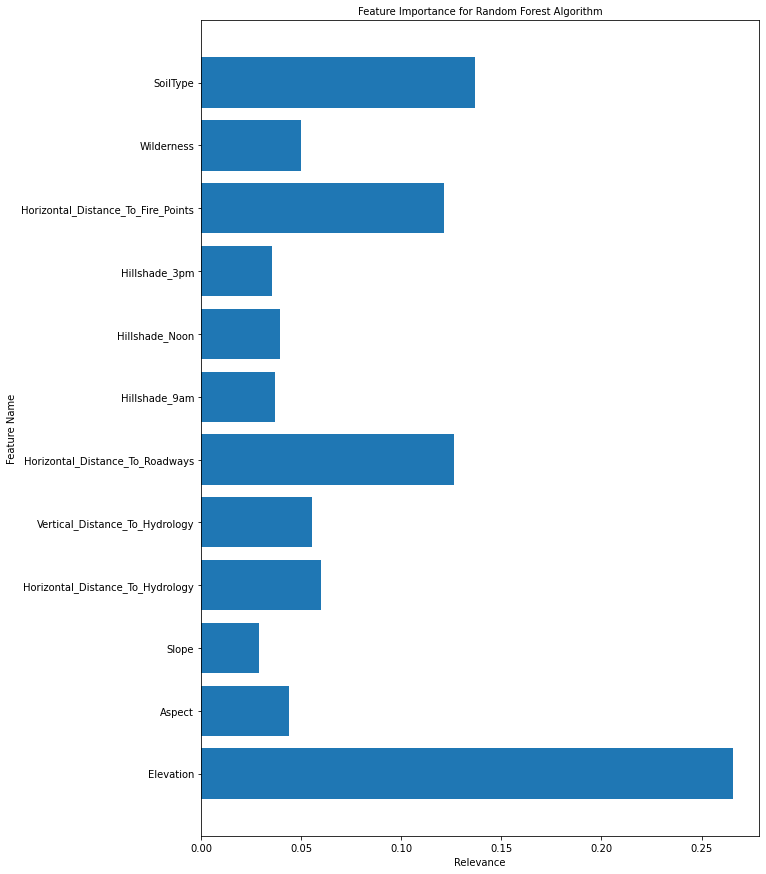

In [16]:
#plot feature importance
plt.figure(figsize=(10,15))
plt.barh(train_df.drop(columns='cov_type').columns.values, feat_rf)
plt.title('Feature Importance for Random Forest Algorithm',fontsize=10)
plt.ylabel('Feature Name')
plt.xlabel('Relevance')
plt.show()



A bar chart showing how important the random forest algorithm found the features in making predictions.

##### Perform Correlation Analysis

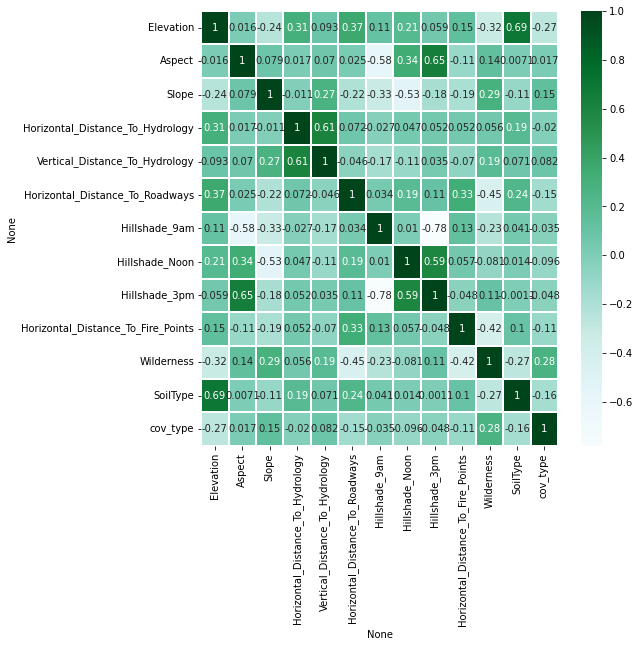

In [17]:
correlation = XY_forest_df.corr()

plt.figure(figsize=(8,8))

sns.heatmap(correlation,
            cmap='BuGn',
            linecolor='white',
            linewidths=1,
            annot=True, 
            xticklabels = True,
            yticklabels= True)


### Feature Selection: CONCLUSIONS AND RECOMMENDATIONS
<hr>

When looking at the features’ correlation and relevance to the model, we recommend dropping column 'Hillshade_3pm’.  Our reasoning is:

1. The variable is strongly correlated with 'Hillshade_Noon' and the Aspect column. Therefore we feel like this additional feature will not bring additional information and increase the complexity of the model
2. The variable has low relevance to the model

##### Check to see if model performance increased after feature selection

In [18]:
train_df2 = train_df.drop(columns='Hillshade_3pm')
val_df2 = val_df.drop(columns='Hillshade_3pm')
test_df2 = test_df.drop(columns='Hillshade_3pm')

x_train2 = train_df2.values[:, :-1]
y_train2  = train_df2.values[:, -1]
x_val2 = val_df2.values[:, :-1]
y_val2  = val_df2.values[:, -1]
x_test2 = test_df2.values[:, :-1]
y_test2  = test_df2.values[:, -1]

rf2 = RandomForestClassifier()
rf2.fit(x_train2, y_train2)
rf_pred2 = rf2.predict(x_val2)
rf_acc2 = accuracy_score(rf_pred2, y_val2)

print("Our random forest classified {:0.2f}% of the of the trees correctly".format(rf_acc2*100))

Our random forest classified 96.26% of the of the trees correctly


After removing the 'Hillshade_3pm’ feature, the model increased its accuracy by .18pp.

# Baseline

### We will set a baseline model to understand how much our other models performance improved

In [23]:
# dummy baseline
dummy = DummyClassifier(strategy='stratified', random_state = 1)

#train the model with training data
dummy.fit(x_train, y_train)

#get accuracy score
baseline_accuracy = round(dummy.score(x_val, y_val),2)
print(f"Our dummy algorithm classified {baseline_accuracy*100}% of the trees correctly")

Our dummy algorithm classified 38.0% of the trees correctly


# KNN Model Analysis and Hyperparameter Tuning

### We will first determine if we should use feature selected dataset or the full data set within our KNN model based on randomly chosen KNN model parameters

In [26]:
# KNN model based on full dataset
KNN_model = KNeighborsClassifier(n_neighbors = 5)
KNN_model.fit(x_train, y_train)
KNN_model_accuracy = round(KNN_model.score(x_val, y_val),5)
print(f"The accuracy of the original KNN model with the full data set is {KNN_model_accuracy*100}%")

The accuracy of the original KNN model with the full data set is 91.825%


In [27]:
# KNN model based on feature selected dataset
KNN_model_fs = KNeighborsClassifier(n_neighbors = 5)
KNN_model_fs.fit(x_train2, y_train2)
KNN_model_fs_accuracy = round(KNN_model_fs.score(x_val2, y_val2),5)
print(f"The accuracy of the KNN model with the feature selected data set is {KNN_model_fs_accuracy*100}%")

The accuracy of the KNN model with the feature selected data set is 92.235%


Because the feature selected model has a higher accuracy of about 0.4%, we will use the feature selected data set for our hyperparameter tuning.

### We will attempt to improve upon our Random Forest model by analyzing a KNN model as well and modifying the following hyperparameters: 
- Number of neighbors 
- Weights 
- Distance formula (Manhattan or Euclidean) 

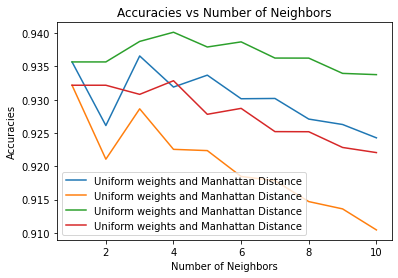

In [29]:
# KNN model analysis
# set hyperparameters
n = [1,2,3,4,5,6,7,8,9,10] # number of neighbors
w_u = 'uniform' # weights{‘uniform’, ‘distance’} or callable, default=’uniform’
w_d = 'distance'
p_value_m = 1 #Power parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2, default=2
p_value_e = 2

# Create KNN models across different numbers of neighbors
UM_combined_accuracies = []
UE_combined_accuracies = []
DM_combined_accuracies = []
DE_combined_accuracies = []

for i in n:
  UM_model = KNeighborsClassifier(n_neighbors=i, weights=w_u, p=p_value_m)
  UM_model.fit(x_train2, y_train2)
  UE_model = KNeighborsClassifier(n_neighbors=i, weights=w_u, p=p_value_e)
  UE_model.fit(x_train2, y_train2)
  DM_model = KNeighborsClassifier(n_neighbors=i, weights=w_d, p=p_value_m)
  DM_model.fit(x_train2, y_train2)
  DE_model = KNeighborsClassifier(n_neighbors=i, weights=w_d, p=p_value_e)
  DE_model.fit(x_train2, y_train2)  

  # Determine the main metric of evaluation: Accuracy
  UM_model_accuracy = UM_model.score(x_val2, y_val2)
  UM_combined_accuracies.append(UM_model_accuracy)
  UE_model_accuracy = UE_model.score(x_val2, y_val2)
  UE_combined_accuracies.append(UE_model_accuracy)
  DM_model_accuracy = DM_model.score(x_val2, y_val2)
  DM_combined_accuracies.append(DM_model_accuracy)
  DE_model_accuracy = DE_model.score(x_val2, y_val2)
  DE_combined_accuracies.append(DE_model_accuracy)

# Plot impact of number of neighbors on accuracies 
plt.figure()
plt.plot(n, UM_combined_accuracies, label = "Uniform weights and Manhattan Distance")
plt.plot(n, UE_combined_accuracies, label = "Uniform weights and Euclidean Distance")
plt.plot(n, DM_combined_accuracies, label = "Distance weights and Manhattan Distance")
plt.plot(n, DE_combined_accuracies, label = "Distance weights and Euclidean Distance")
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracies')
plt.legend()
plt.title('Accuracies vs Number of Neighbors')
plt.show()

The highest performing KNN model has 4 neighbors, uses the distance weight and manhattan distance. Below you will see our further analysis of metrics of evaluation to evaluate model performance.

In [32]:
# KNN model with the hyperparameters that produce the highest accuracy: distance weights, Manhattan Distance, and 4 neighbors
# set hyperparameters

# Create KNN model
best_KNN_model = KNeighborsClassifier(n_neighbors=4, weights='distance', p=1)
best_KNN_model.fit(x_train2, y_train2)

# Determine the main metric of evaluation: Accuracy
best_KNN_model_accuracy = best_KNN_model.score(x_val2, y_val2)
print(f"Accuracy of the KNN model with distance weights, Manhattan Distance, and 4 neighbors is {best_KNN_model_accuracy}")

# Determine the supplementary metrics of evaluation: Precision, Recall, and F1
KNN_pred_labels = best_KNN_model.predict(x_val2)
KNN_classification = classification_report(y_val2, KNN_pred_labels) # reports Precision, Recall, and F1 Score
print(f"The classification of KNN model is {KNN_classification}")

# Create a confusion matrix for the model
print(confusion_matrix(y_val2, KNN_pred_labels))

Accuracy of the KNN model with distance weights, Manhattan Distance, and 5 neighbors is 0.940136834984544
The classification of KNN model is               precision    recall  f1-score   support

         1.0       0.94      0.94      0.94     42595
         2.0       0.95      0.95      0.95     56956
         3.0       0.93      0.92      0.92      7334
         4.0       0.85      0.81      0.83       532
         5.0       0.85      0.82      0.84      1901
         6.0       0.84      0.86      0.85      3431
         7.0       0.95      0.95      0.95      4034

    accuracy                           0.94    116783
   macro avg       0.90      0.89      0.90    116783
weighted avg       0.94      0.94      0.94    116783

[[39987  2378     3     0    34     9   184]
 [ 2126 54271   142     3   218   159    37]
 [    3   129  6761    48    17   376     0]
 [    0     2    72   432     0    26     0]
 [   41   266    18     0  1568     8     0]
 [    6   142   310    24     6  2943

The highest performing KNN model has an accuracy of 94%. This model used data preprocessing, feature engineering, and hyperparameter tuning to find the optimal model. This model is 56% better than predicting forest cover types than our baseline model. Based on the confusion matrix, we can see that forest covers of type 1 are most regulary confused for type 2 and vice versa, forest covers of type 2 are often mistaken for type 1. The most mistakes were found when predicting forest cover type 2 with 2949 incorrect predictions.